## Math Primer

Let $X$ and $Y$ be two Gaussian random variables with zero mean and variances $\sigma_1^2$ and $\sigma_2^2$ and a correlation coefficient $\rho$. Then $Z=XY$ follows the distribution

$$p_Z(z) = \frac{1}{\pi \sigma_1 \sigma_2 \sqrt{1-\rho^2}} \exp\left(\frac{\rho z}{\sigma_1\sigma_2(1-\rho^2)}\right) K_0\left(\frac{|z|}{\sigma_1\sigma_2(1-\rho^2)}\right) $$


Source: https://ieeexplore.ieee.org/document/7579552

$E(Z) = \rho \sigma_1 \sigma_2$, by definition.
This is achieved through the skewness of the distribution.
The logarithmic divergence of $K_0$ near 0 implies that the distribution has its peak at 0 and exhibits a kink-like behavior.

$Var(Z) = (1+\rho^2)\sigma_1^2\sigma_2^2$ which is the least when $X$ and $Y$ are independent.

Given a sample of $Z$, we can either estimate $\rho$ and $\sigma_1\sigma_2$ by measuring the sample mean and sample variance or by fitting the $p_Z(z)$ curve to a histogram.

If we have multiple realizations of $Z$, then the average of all noise realizations $\overline{Z}$ is Gaussian distributed due to Central Limit Theorem.

In [146]:
import sys
sys.path.append('/project/kannawad/repo/pipe_analysis/python/lsst/pipe/analysis/')
sys.path.append('/project/kannawad/repo/pipe_tasks/python/lsst/pipe/tasks/')
sys.path.append('/software/lsstsw/stack_20210813/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/')
import lsst.daf.butler as dafButler
import lsst.afw.image as afwImage
import numpy as np
import json
import matplotlib
import matplotlib.cm as cm
%matplotlib notebook
import matplotlib.pyplot as plt
import lsst.afw.display as afwDisplay
import itertools

In [5]:
sys.path.append('/project/kannawad/repo/pipe_analysis/python/lsst/pipe/analysis/')
sys.path.append('/project/kannawad/repo/pipe_tasks/python/lsst/pipe/tasks/')
from utils import RhoStatistics

In [6]:
import sys
sys.path.append('/project/kannawad/repo/pipe_tasks/python/lsst/pipe/tasks/')

Set up tickets/DM-32700 branch of `pipe_tasks`

In [3]:
! setup -j -r /project/kannawad/repo/pipe_tasks

In [5]:
import computeCovariance

## Choose between RC2 and DC2

Run one of the following two blocks depending on whether you want to look at HSC RC2 data or DESC DC2 data

In [169]:
# Define RC2 weeklies

# Define weeklies

w42 = "HSC/runs/RC2/w_2021_42/DM-32248"
w38 = "HSC/runs/RC2/w_2021_42/DM-31815"
w34 = "HSC/runs/RC2/w_2021_34/DM-31477"
w30 = "HSC/runs/RC2/w_2021_30/DM-31184"
w26 = "HSC/runs/RC2/w_2021_26/DM-30864"
w22 = "HSC/runs/RC2/w_2021_22/DM-30424"
w18 = "HSC/runs/RC2/w_2021_18/DM-29946"
w14 = "HSC/runs/RC2/w_2021_14/DM-29519"

repo = "/repo/main"
dataId = {'visit':23868, 'tract':9615, 'patch':19, 'band':'r', 'skymap':'hsc_rings_v1', 'instrument':'HSC'}
weekly = w42

In [203]:
# Define DC2 weeklies

w44 = "2.2i/runs/test-med-1/w_2021_44/DM-32391"
w40 = "2.2i/runs/test-med-1/w_2021_40/DM-32024"
w36 = "2.2i/runs/test-med-1/w_2021_36/DM-31699"
w32 = "2.2i/runs/test-med-1/w_2021_32/DM-31351"
w28 = "2.2i/runs/test-med-1/w_2021_28/DM-31067"

repo = "/repo/dc2/"
dataId = {'visit': 242597, 'tract':3828, 'patch':4, 'band':'r', 'skymap':'DC2', 'instrument':'LSSTCam-imSim'}
weekly = w40

In [139]:
from scipy.optimize import curve_fit
from scipy.special import kn

def gauss(x, mu=0, sigma=1):
    return np.exp(-0.5*((x-mu)/sigma)**2)/np.sqrt(2*np.pi*sigma**2)

def gaussXgauss(x, sigma12=1, rho=0):
    """
    Distribution corresponding to the product of two Gaussian RVs
    
    Since the degeneracy between sigma_1 and sigma_2 cannot be broken based on
    the distribution alone, treat the product as a single parameter sigma12.
    """
    ssr = sigma12*(1-rho*rho)
    return kn(0, abs(x)/ssr)*np.exp(rho*x/ssr)*(1-rho**2)**0.5/(np.pi*ssr)

If the noise in `calexp` is Gaussian (it is in our Monte Carlo simulations), then the noise in `deepCoadd_warp` and `deepCoadd` are also Gaussian, since the operation is linear.

In [166]:
def get_cov_elements(runId, nx=7, ny=7, dataset="deepCoadd", dataId=dataId):
    cov_dict = {}
    butler_noise = dafButler.Butler(repo, collections=[f"u/kannawad/DM-23253-noises/run{runId}"])
    #noise_coadd = butler_noise.get("deepCoadd", dataId=dataId)
    noise_coadd = butler_noise.get("deepCoadd", dataId=dataId)

    for dx in range(nx):
        for dy in range(ny):
            sliceA_X, sliceB_X = slice(7+dx, -7, None), slice(7, -(dx+7), None)
            sliceA_Y, sliceB_Y = slice(7+dy, -7, None), slice(7, -(dy+7), None)
            imA, varA = noise_coadd.image.array[sliceA_X, sliceA_Y], noise_coadd.variance.array[sliceA_X, sliceA_Y]
            imB, varB = noise_coadd.image.array[sliceB_X, sliceB_Y], noise_coadd.variance.array[sliceB_X, sliceB_Y]
            cov_dict[(dx, dy)] = imA*imB/(varA*varB)**0.5
            
    return cov_dict
 

## Visualize the pure noise images

The set of collections in `u/kannawad/DM-23253-noises/` contains images obtained by substituting `calexp` for a white Gaussian noise image.

Only `deepCoadd_warp` and `deepCoadd` datasets are persisted. The `calexp` are pure noise images made in-situ and are not persisted.

<IPython.core.display.Javascript object>


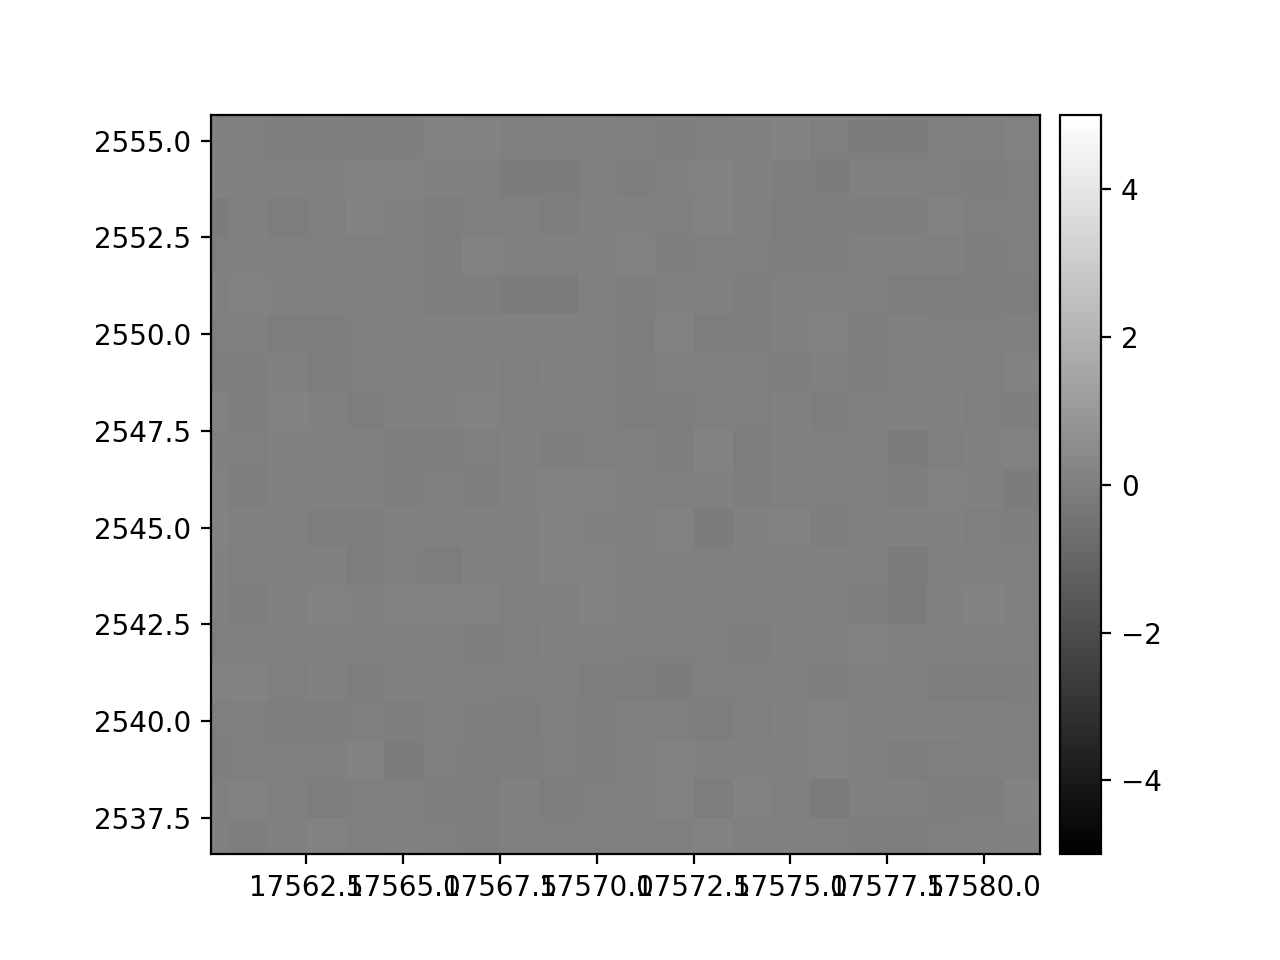

In [205]:
runId = 23
butler_noise = dafButler.Butler(repo, collections=[f"u/kannawad/DM-23253-noises/run{runId}"])
noise_coadd = butler_noise.get("deepCoadd", dataId=dataId)
display = afwDisplay.Display(frame=1, backend='matplotlib')
display.scale('linear', min=-5, max=5)
display.setMaskTransparency(0.0)
display.mtv(noise_coadd.image)

#### Compute a covariance matrix PER PIXEL and average over noise realizations



In [206]:
cov_dict = {}
_bins = 200
runIds = [21, 44, 76, 99,]
for runId in runIds:
    butler_noise = dafButler.Butler(repo, collections=[f"u/kannawad/DM-23253-noises/run{runId}"])
    noise_coadd = butler_noise.get("deepCoadd", dataId=dataId)

    for dx in range(7):
        for dy in range(7):
            cov = {}
            # These give rho = 0.15 for dx=1, dy=0
            sliceA_X, sliceB_X = slice(7+dx, -7, None), slice(7, -(dx+7), None)
            sliceA_Y, sliceB_Y = slice(7+dy, -7, None), slice(7, -(dy+7), None)

            # sliceA_X, sliceA_Y = slice(dx, None, None) if dx else slice(None, None, None), slice(None, None, None)
            # sliceB_X, sliceB_Y = slice(None, -dx, None) if dx else slice(None, None, None), slice(None, None, None)
        
            imA, varA = noise_coadd.image.array[sliceA_X, sliceA_Y], noise_coadd.variance.array[sliceA_X, sliceA_Y]
            imB, varB = noise_coadd.image.array[sliceB_X, sliceB_Y], noise_coadd.variance.array[sliceB_X, sliceB_Y]
            cov_dict[(runId, dx, dy)] = imA*imB/(varA*varB)**0.5

<IPython.core.display.Javascript object>


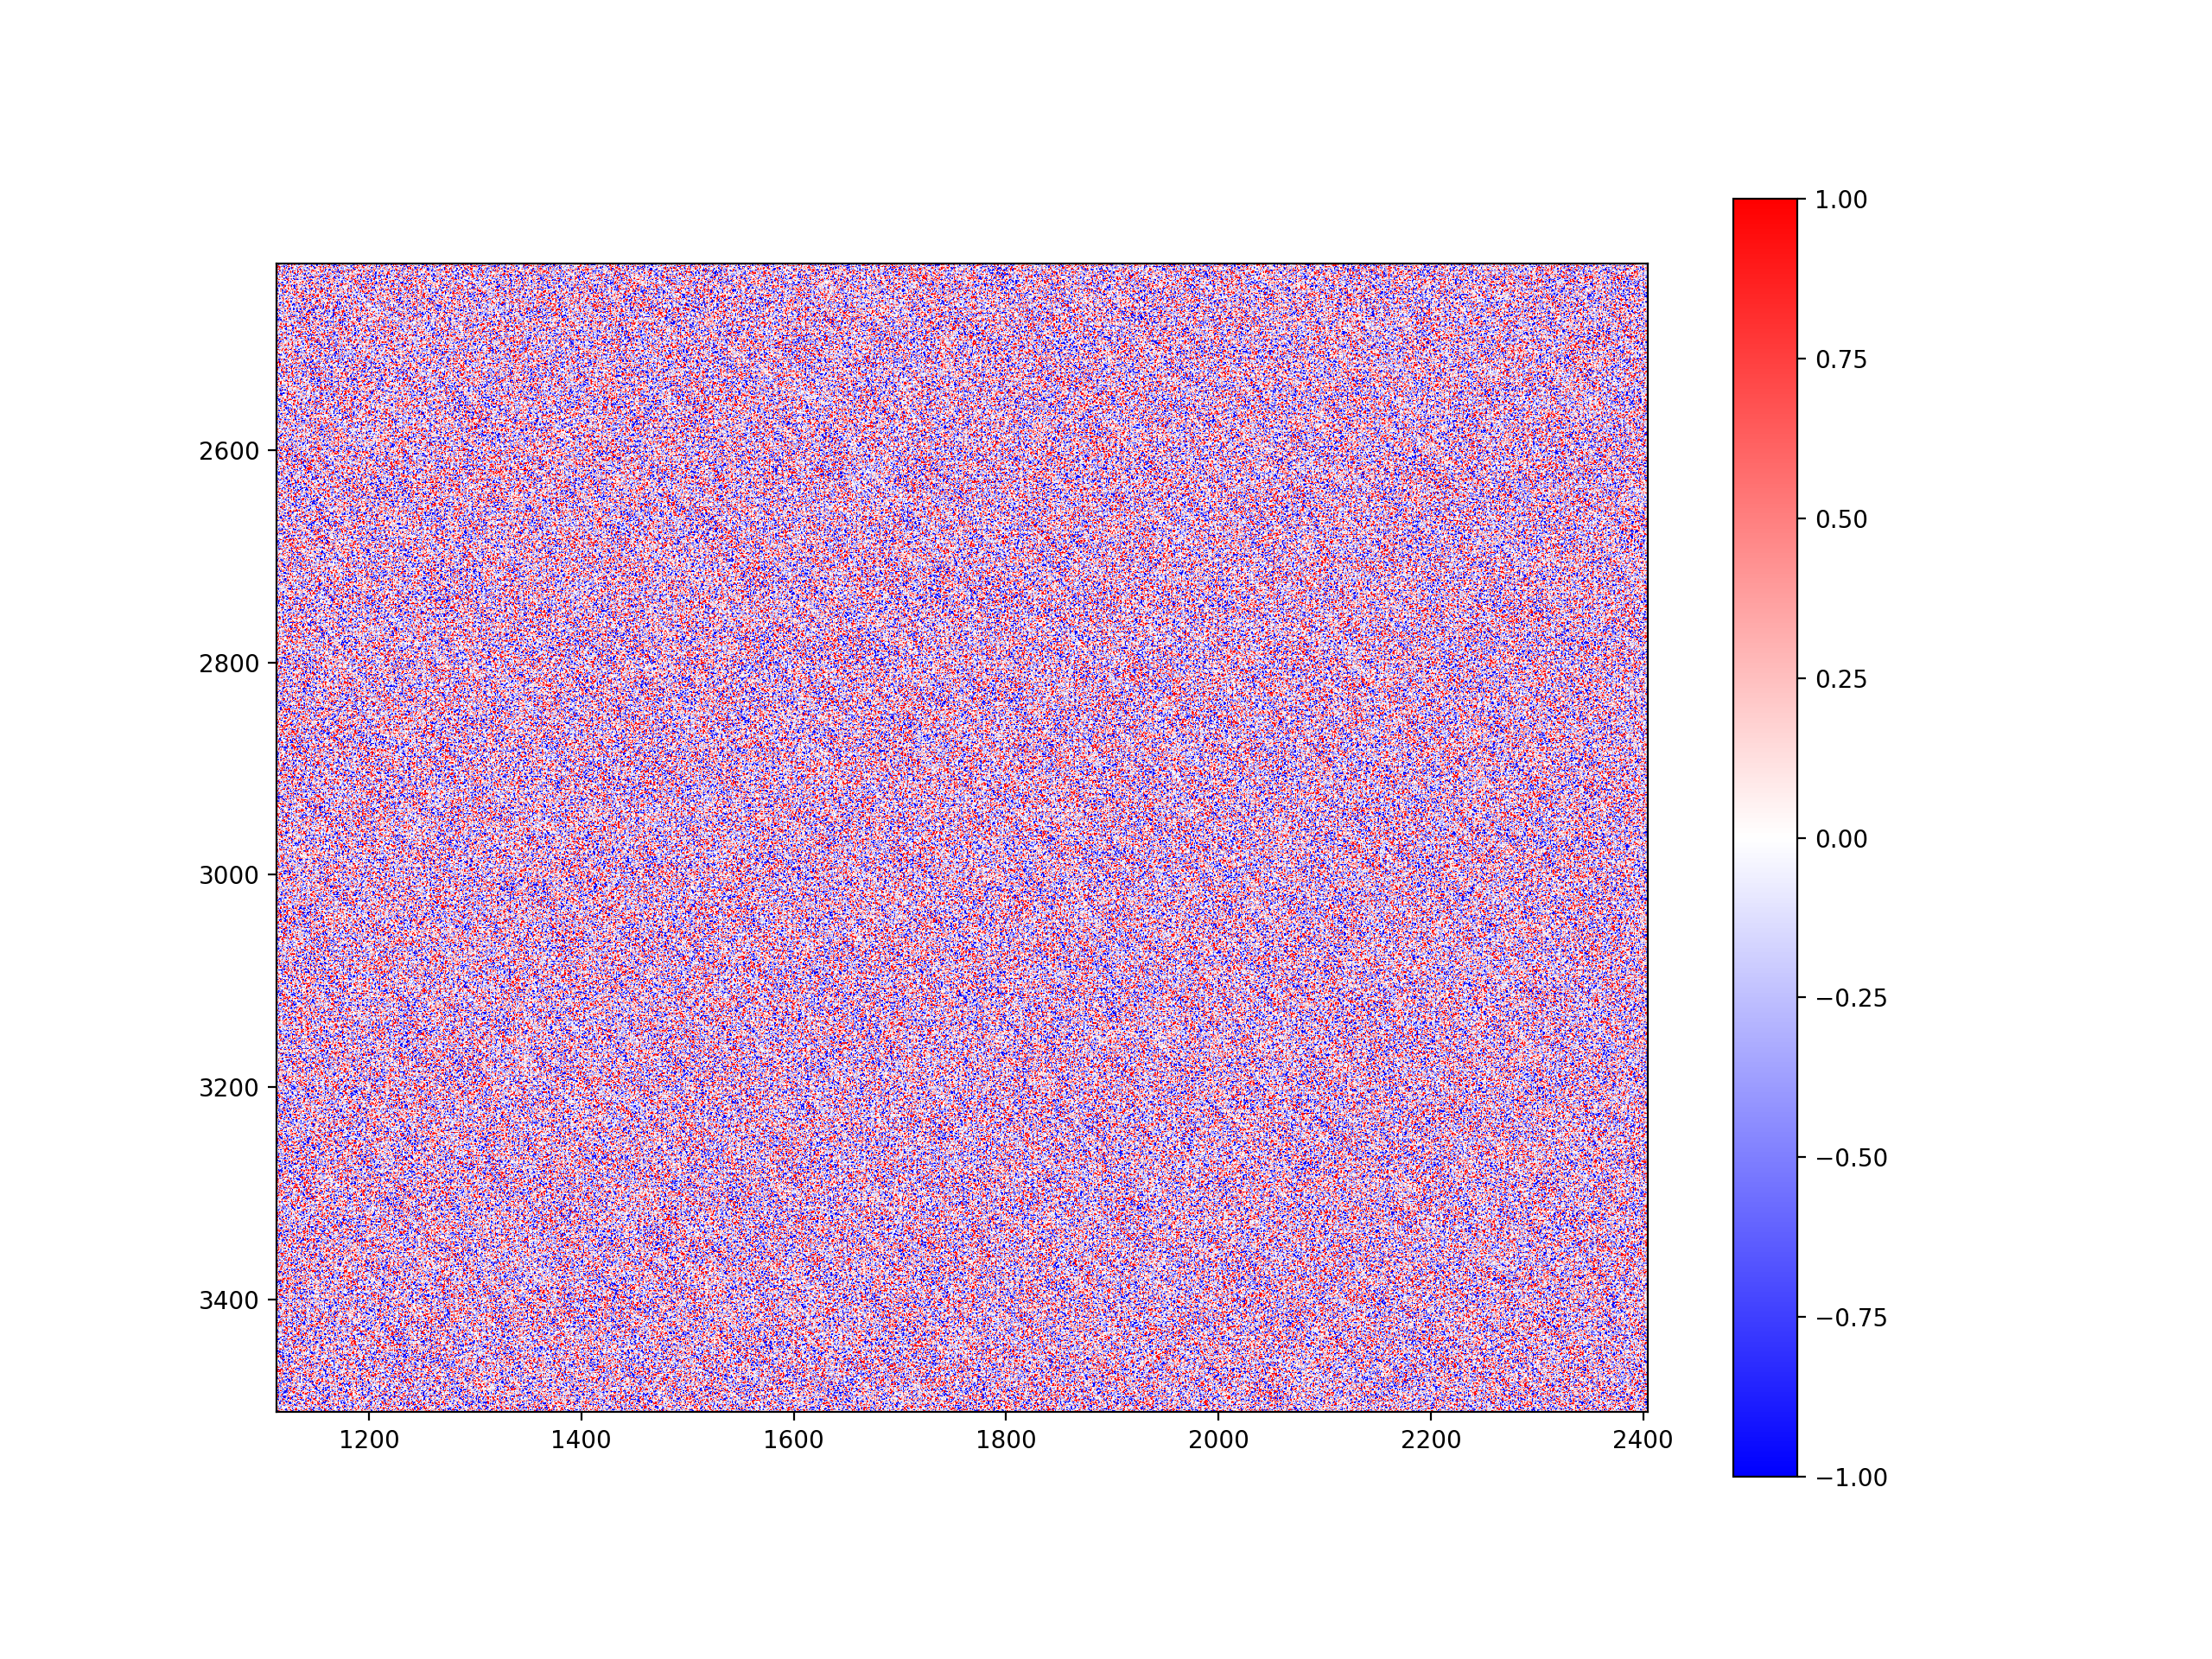

In [207]:
fig, ax = plt.subplots()
_im = ax.imshow(cov_dict[(21,6,6)], cmap=cm.bwr, vmin=-1, vmax=1)
fig.colorbar(_im, ax=ax)

It appears like $Z=XY$ has some sort of spatial pattern, or it could be my eye tricking me. To check if there is a persistent pattern, we do an ensemble averaging over multiple noise realizations. If the pattern is persistent, then $Var(\overline{Z}) \lesssim Var(Z)$. If the pattern is random, then $Var(\overline(Z)) \approx Var(Z)/\sqrt{N}$, where $N$ is the number of noise realizations.

Now, do an ensemble averaging, i.e., average over all noise realizations

In [22]:
%%time
mean_cov_dict = {}
n_cov_dict = {}
mean_cov_dict[(dx, dy)] = np.zeros_like(cov_dict[(99,dx, dy)])
n_cov_dict[(dx, dy)] = np.zeros_like(cov_dict[(99,dx, dy)])
for runId in range(20,99):
    cov = get_cov_elements(runId)
    dx, dy= 1,0
    mean_cov_dict[(dx, dy)] += cov[(dx, dy)]*(~np.isnan(cov[(dx, dy)]))
    n_cov_dict[(dx, dy)] += (~np.isnan(cov[(dx, dy)])).astype(int)
    
dx, dy= 1,0
mean_cov_dict[(dx, dy)] /= n_cov_dict[(dx, dy)]

CPU times: user 7min 46s, sys: 3min 35s, total: 11min 22s
Wall time: 13min 44s


Let us look at the distribution of the $Z$ values for a handful number noise realizations, and then for the ensemble average.

If the coadd (warp) had uncorrelated noise, then the distribution is a should be centered around 0 and have a standard deviation of $1$. The distribution for individual noise realizations should be $p_Z(z)$ for some parameters, but should tend to Gaussian for the ensemble mean due to CLT.

<IPython.core.display.Javascript object>


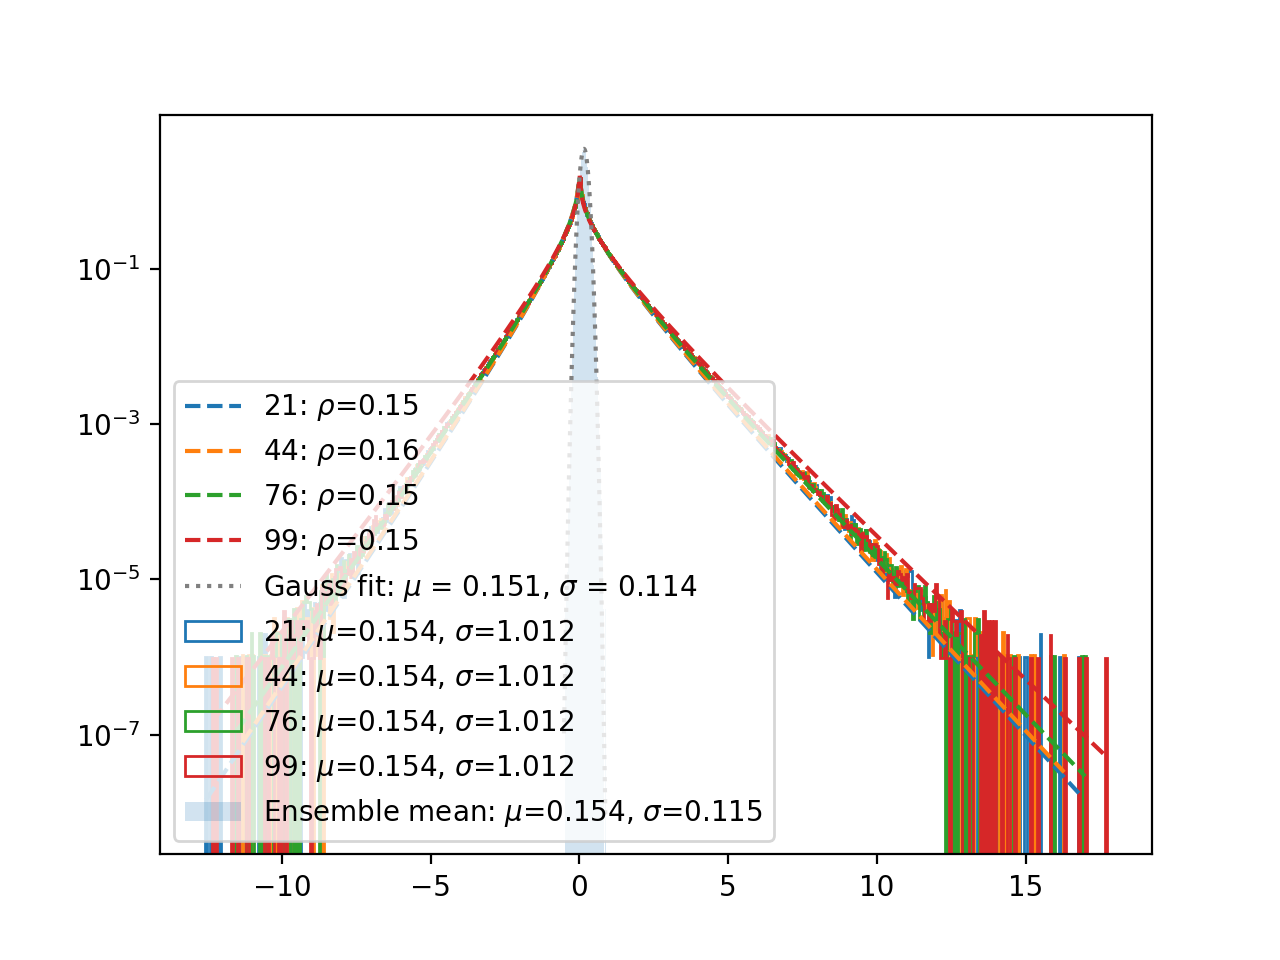

21 [0.93510539 0.15474481]
44 [0.94370581 0.15608452]
76 [0.98171784 0.15328884]
99 [1.07371309 0.14853921]


In [211]:
fig, ax = plt.subplots()
for cId, runId in enumerate(runIds):
    y = cov_dict[(runId, 1, 0)].flatten()
    _n, _bins, _patches = ax.hist(y, bins=500, color=f"C{cId}", histtype='step', density=True, label=r"%d: $\mu$=%.3f, $\sigma$=%.3f" % (runId, np.nanmean(y), np.nanstd(y)))
    _bincenters = 0.5*(_bins[1:]+_bins[:-1])
    popt, pcov = curve_fit(gaussXgauss, _bincenters[np.abs(_bincenters)<5], _n[np.abs(_bincenters)<5], p0=[1., 0.])
    ax.plot(_bincenters, gaussXgauss(_bincenters, *popt), ls='--', color=f"C{cId}", label=r"%d: $\rho$=%.2f" % (runId, popt[1]))
    print(runId, popt)
    
y = mean_cov_dict[(1,0)].flatten()
_n, _bins, _patches = ax.hist(y, bins=100, alpha=0.2, density=True, label=r'Ensemble mean: $\mu$=%.3f, $\sigma$=%.3f' % (np.nanmean(y), np.nanstd(y)))
_bincenters = 0.5*(_bins[1:]+_bins[:-1])
popt, pcov = curve_fit(gauss, _bincenters, _n)
mean, std = popt
ax.plot(_bincenters, gauss(_bincenters, *popt), color='gray', ls=':', label=r"Gauss fit: $\mu$ = %.3f, $\sigma$ = %.3f" % (popt[0], popt[1]) )
ax.set_yscale('log')
_ = ax.legend(loc='best')

The mean appears quite robust!

All measurements point to $\rho \approx 0.15$.

Let us check if it is similar for the real data

In [201]:
butler = dafButler.Butler(repo, collections=[weekly])
coadd = butler.get("deepCoadd", dataId=dataId)

maskedImage = coadd.maskedImage
maskPlanes = ["DETECTED", "DETECTED_NEGATIVE", "BAD", "SAT", "NO_DATA", "INTRP"]
maskVal = maskedImage.mask.getPlaneBitMask(maskPlanes)
isGood = (((maskedImage.mask.array & maskVal) == 0)
          & np.isfinite(maskedImage.image.array)
          & np.isfinite(maskedImage.variance.array)
          & (maskedImage.variance.array > 0))

coadd.image.array[~isGood] = np.nan

## Visualize the noise regions (+undetected sources) in the image

Let us take a real image and look at it. If nothing, let us make sure we are not reading in pure-noise coadds

<IPython.core.display.Javascript object>


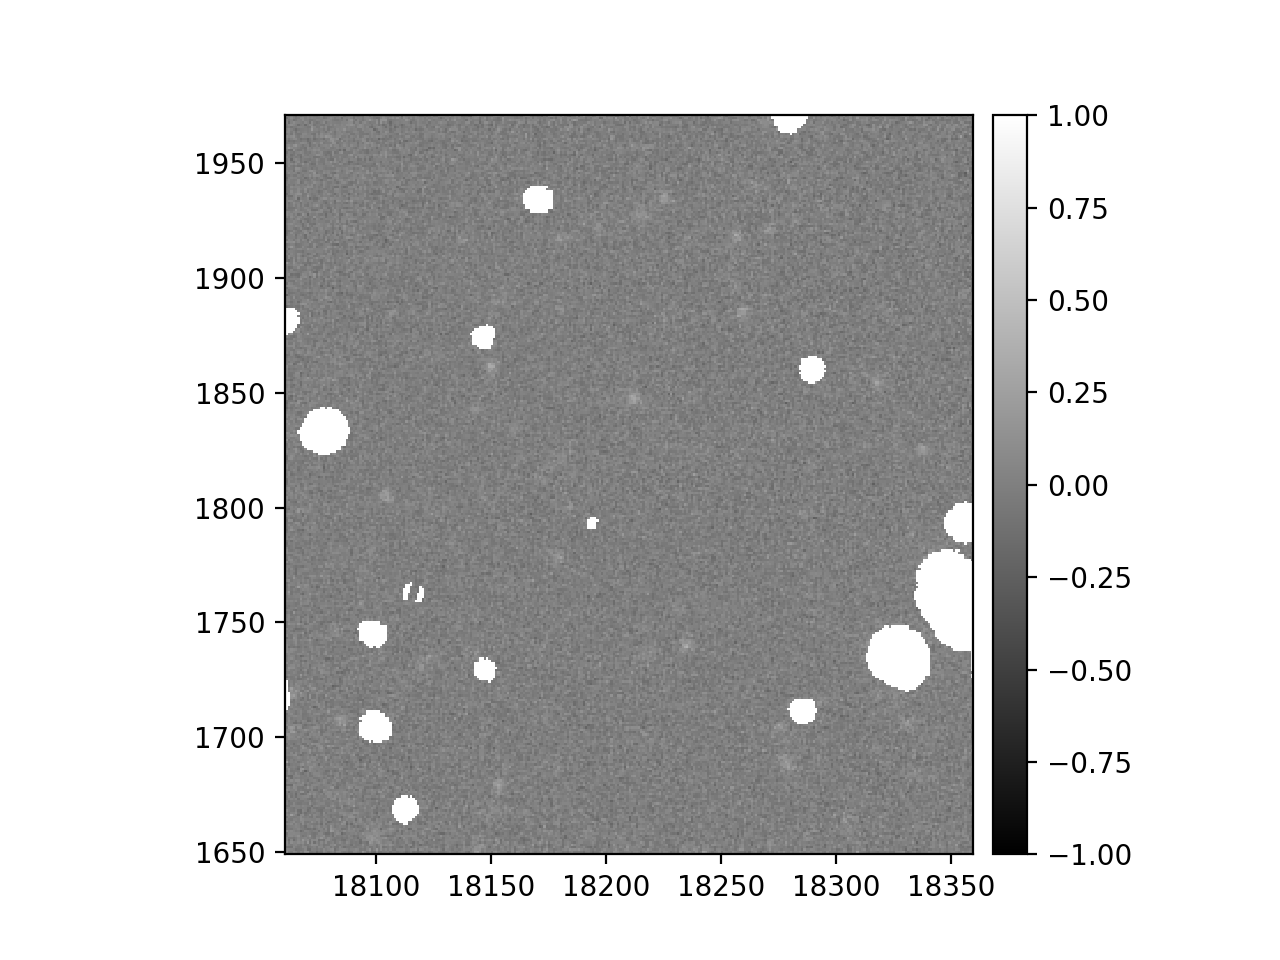

In [212]:
display = afwDisplay.Display(frame=1, backend='matplotlib')
display.scale('linear', min=-1, max=1)
display.mtv(coadd.image)

The presence of undetected sources will certainly lead to additional positive correlation of the noise.

<IPython.core.display.Javascript object>


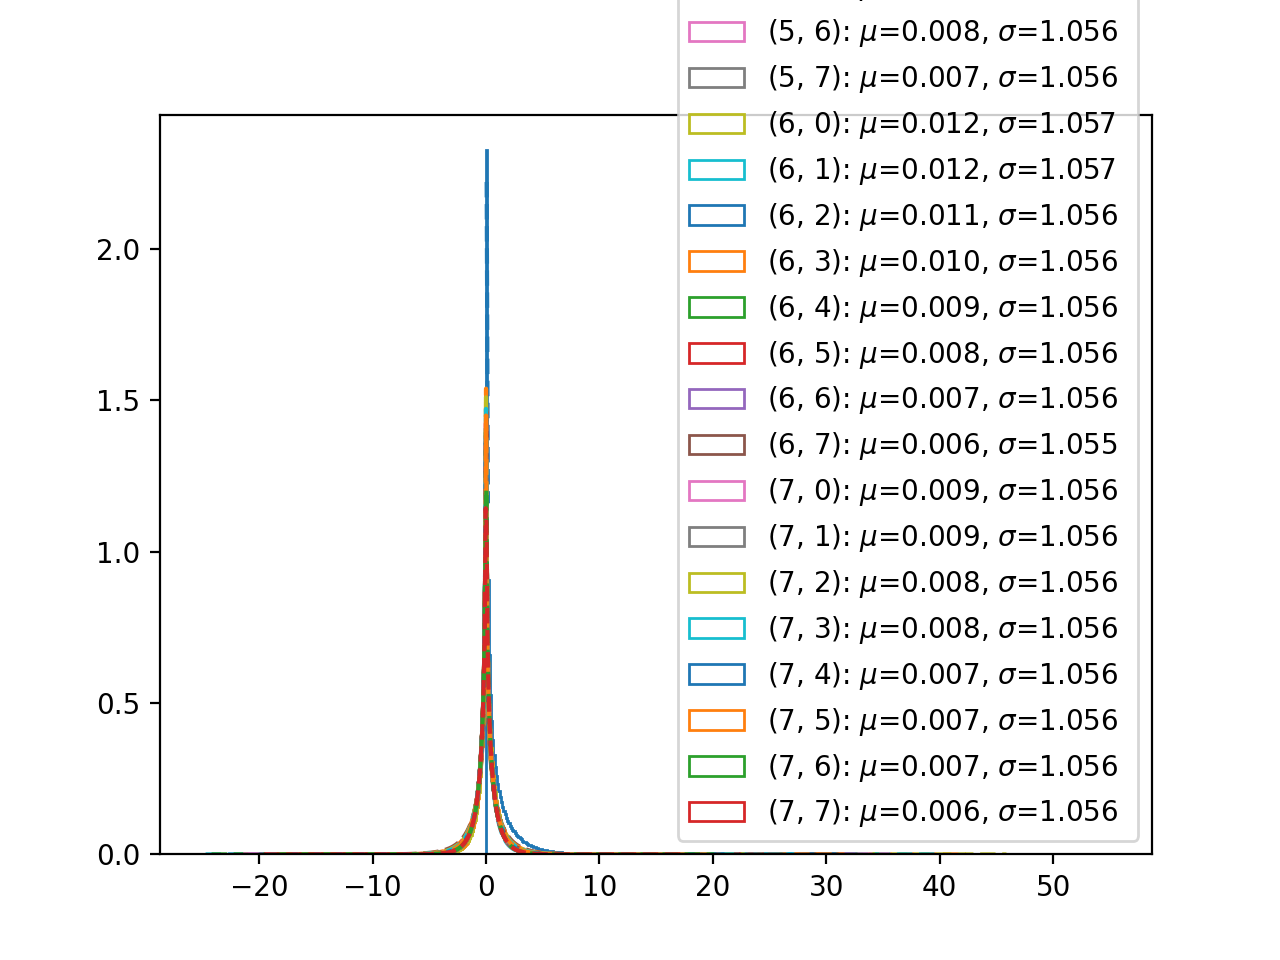

/tmp/ipykernel_2706068/3502759483.py:9: RuntimeWarning: invalid value encountered in double_scalars
  return kn(0, abs(x)/ssr)*np.exp(rho*x/ssr)*(1-rho**2)**0.5/(np.pi*ssr)
/tmp/ipykernel_2706068/3502759483.py:9: RuntimeWarning: overflow encountered in exp
  return kn(0, abs(x)/ssr)*np.exp(rho*x/ssr)*(1-rho**2)**0.5/(np.pi*ssr)
/tmp/ipykernel_2706068/3502759483.py:9: RuntimeWarning: invalid value encountered in multiply
  return kn(0, abs(x)/ssr)*np.exp(rho*x/ssr)*(1-rho**2)**0.5/(np.pi*ssr)


(dx=0, dy=0): Fit parameters: rho=0.9974, sigma1*sigma2=0.524; Ensemble statistics: mu=1.0562, sigma^2=2.394
(dx=0, dy=1): Fit parameters: rho=0.1719, sigma1*sigma2=0.977; Ensemble statistics: mu=0.2069, sigma^2=1.301
(dx=0, dy=2): Fit parameters: rho=-0.0123, sigma1*sigma2=1.106; Ensemble statistics: mu=0.0108, sigma^2=1.206
(dx=0, dy=3): Fit parameters: rho=0.0284, sigma1*sigma2=1.114; Ensemble statistics: mu=0.0394, sigma^2=1.161
(dx=0, dy=4): Fit parameters: rho=0.0150, sigma1*sigma2=1.001; Ensemble statistics: mu=0.0229, sigma^2=1.132
(dx=0, dy=5): Fit parameters: rho=0.0121, sigma1*sigma2=0.986; Ensemble statistics: mu=0.0165, sigma^2=1.122
(dx=0, dy=6): Fit parameters: rho=0.0110, sigma1*sigma2=1.092; Ensemble statistics: mu=0.0125, sigma^2=1.118
(dx=0, dy=7): Fit parameters: rho=0.0099, sigma1*sigma2=0.975; Ensemble statistics: mu=0.0100, sigma^2=1.115
(dx=1, dy=0): Fit parameters: rho=0.1667, sigma1*sigma2=0.942; Ensemble statistics: mu=0.2072, sigma^2=1.299
(dx=1, dy=1): Fit 

In [213]:
# Generate a 7x7 covariance matrix and plot the different Z-distributions

fig, ax = plt.subplots()
cov_matrix = afwImage.ImageF(8,8)
dxdy = itertools.product(range(8), range(8))
for cId, (dx,dy) in enumerate(dxdy):
    sliceA_X, sliceB_X = slice(7+dx, -7, None), slice(7, -(dx+7), None)
    sliceA_Y, sliceB_Y = slice(7+dy, -7, None), slice(7, -(dy+7), None)

    imA, varA = coadd.image.array[sliceA_X, sliceA_Y], coadd.variance.array[sliceA_X, sliceA_Y]
    imB, varB = coadd.image.array[sliceB_X, sliceB_Y], coadd.variance.array[sliceB_X, sliceB_Y]
    y = (imA*imB/(varA*varB)**0.5).flatten()
    _n, _bins, _patches = ax.hist(y, bins=500, color=f"C{cId}", histtype='step', density=True, label=r"(%d, %d): $\mu$=%.3f, $\sigma$=%.3f" % (dx, dy, np.nanmean(y), np.nanstd(y)))
    _bincenters = 0.5*(_bins[1:]+_bins[:-1])
    try:
        popt, pcov = curve_fit(gaussXgauss, _bincenters[np.abs(_bincenters)<2], _n[np.abs(_bincenters)<2], p0=[1., 0.])
    
    
        ax.plot(_bincenters, gaussXgauss(_bincenters, *popt), ls='--', color=f"C{cId}", label=r"(%d, %d): $\rho$=%.4f" % (dx, dy, popt[1]))
    except RuntimeError:
        popt = (-99, -99)
    mu, sigma2 = np.nanmean(y), np.nanvar(y)
    cov_matrix.array[dx, dy] = mu
    print("(dx=%d, dy=%d): Fit parameters: rho=%.4f, sigma1*sigma2=%.3f; Ensemble statistics: mu=%.4f, sigma^2=%.3f" % (dx, dy, popt[1], popt[0], mu, sigma2))
    
_ = ax.legend(loc='best')


<IPython.core.display.Javascript object>


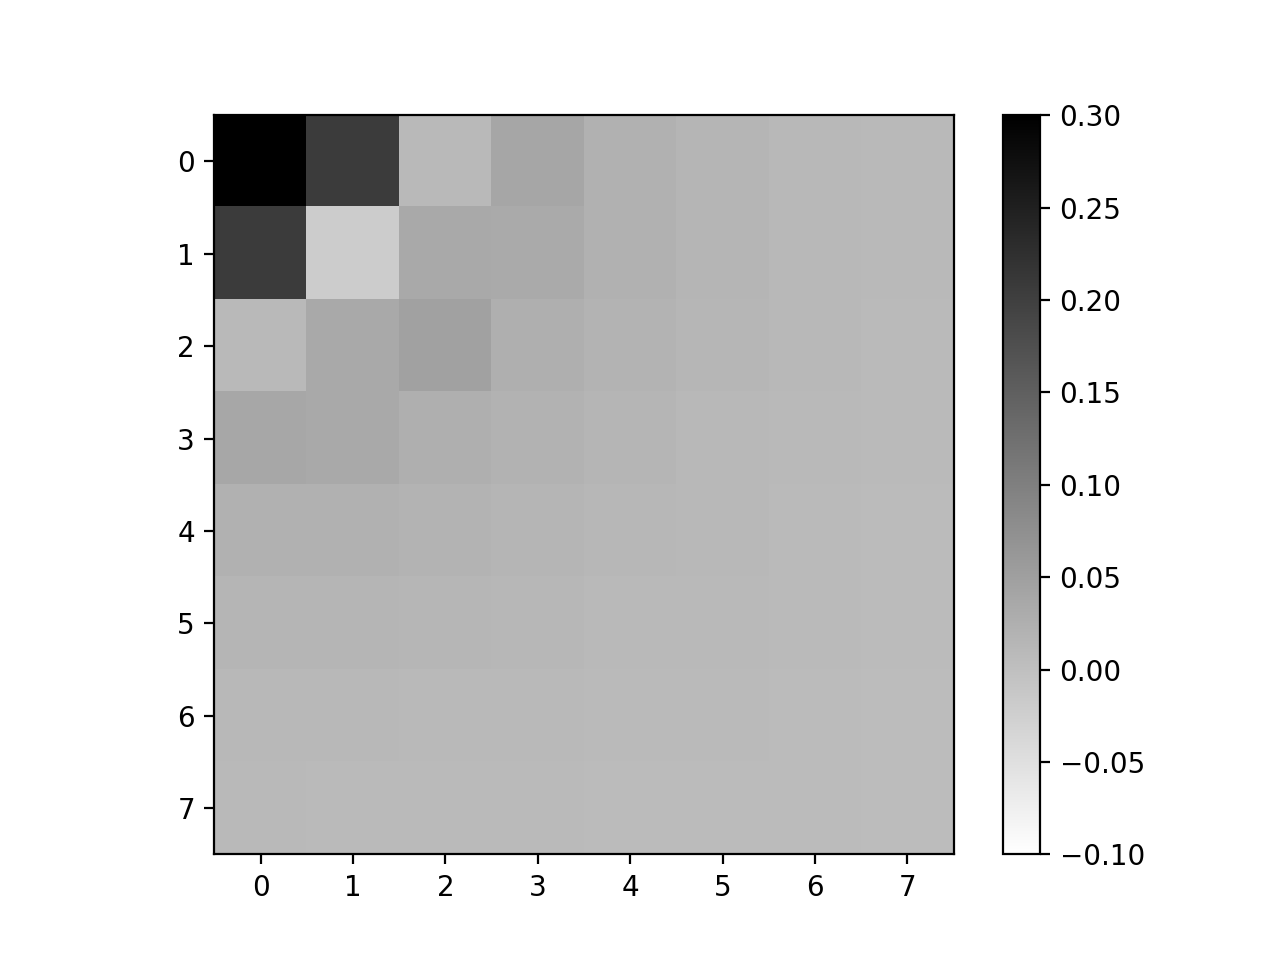

In [217]:
# Plot the correlation matrix
# The correlation matrix is not exactly symmetric since the means are calculated from different samples of Z
# However, the approximate symmetry indicates that the correlations are isotropic
# In the notebook mode, hover the cursor over the pixel to see the exact values

fig, ax = plt.subplots()
_im = ax.imshow(cov_matrix.array, cmap=cm.gray_r, vmin=-0.1, vmax=0.3)
_cbar = fig.colorbar(_im, ax=ax)

# Conclusions

- There are no noticeable spatial dependence in the noise correlations
- The correlations are sufficiently isotropic
- The adjacent pixels exhibit a correlation coefficient of about 0.15-0.2
- The correlation matrix can be captured by a 3x3 matrix if 3rd order Lanczos kernel was used for warping, or 5x5 matrix for 5th order Lanczos.

It remains to be seen if we need a 'full' correlation matrix to calculate the uncertainties in fluxes and shapes more accurately.